# Adaptive Computation

This lab section is based on [Belledonne et al., 2025](https://psycnet.apa.org/record/2026-32727-001). See https://github.com/CNCLgithub/AdaptiveComputation for the main repo. 

## Dependencies

If running this notebook for the firs time, please set `INSTALL=true` below. 

In [1]:
INSTALL = false
if INSTALL
    using Pkg
    Pkg.activate("lab_ac");
    Pkg.add("Gen");
    Pkg.add(url="https://github.com/CNCLgithub/GenRFS");
    Pkg.add("StaticArrays");
    Pkg.add("Luxor");
end

# Outline

In this lab section, we will implement a simplified version of the adaptive computation architecture (AC) while preserving its core components. We will follow the same outline of the paper. First, we will implement a Fixed Resource Model that introduces the domain of object tracking and provides a non-attention model. Then, we will implement a basic version of AC, and visualize its behavior as it rations computations on-the-fly across objects and moments. 



## Environment

In [2]:
using Pkg
Pkg.activate("lab_ac");

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-09/lab_ac`


In [3]:
using Gen
using GenRFS
using StaticArrays

# Fixed Resource Model

(MOT specific components)

## The domain: Multiple Object Tracking

The case study for this lab is Multiple Object Tracking ([Pylyshyn, Z. W., & Storm, R. W. (1988). *Spatial Vision*](https://doi.org/10.1163/156856888x00122)). (also see this [demo](https://perception.yale.edu/DemoFiles/MOT-Basics/MOT.mp4)). The task is straight forward. First, subjects see an array of initially motionless discs, with a subset flashing indicated their status as targets. After a few seconds, the flashing stops, all objects look identical, and begin to move about the display independently and unpredictably. 

Next, we will implement a world model that be inverted (using Bayesian inference) to perform object tracking.

<center>
<img src="./mot.gif" alt="Multiple Object Tracking" width="300" height="200">
</center>

## World Model

In general, a world model defines a collection of *structure preserving* rules and representations.
Here, our world model will define a scene of `n` 2D discs. 

In terms of *representations* $S$, each disc $s_i$ will have a position and instantaneous velocity. 

In terms of *rules*, the world model defines how objects *move* and *appear*. These map onto prior over dynamics (how object states evolve over time) $Pr(S^{(0)}) \prod\limits_t^T Pr(Pr(S^{(t)})\mid S^{(t-1)})$ and a likelihood $Pr(X^{(t)} \mid S^{(t)})$, respectively. 

In [4]:
struct WMParams
    "Number of objects"
    n::Int64
    "Height of the display in world units"
    height::Float64
    "Width of the display in world units"
    width::Float64
    "Radius of a tracker / Disc"
    radius::Float64
    "Average velocity of a tracker"
    vel::Float64
    "The standard deviation of velocity jittering"
    jitter::Float64
    "Standard deviation of observation noise"
    obs_noise::Float64
end

"A helper 2D Float64 Static Array"
const S2V = SVector{2, Float64}

struct Disc 
    pos::S2V
    vel::S2V
end

### The prior

Our prior will have two components: (1) a naive prior over initial state, (2) a pseudo-Brownian prior over object movements.

Starting with the naive prior over the initial state, $Pr(S^{(0)})$, each object is treated as an independent, uniform distribution over the rectangular bounds of the scene.

Thus, $Pr(S^{(0)})$ factorizes to: 

$$
Pr(S^{(0)}) = \prod_{s_i \in S^{(0)}} Pr(s_i)
$$

Here we implement one draw over an object $Pr(s_i)$

In [5]:
"""
The lower and upper bounds that a disc can start.
"""
function tracker_bounds(p::WMParams)
    xs = (-0.5*p.width + p.radius, 0.5*p.width - p.radius)
    ys = (-0.5*p.height + p.radius, 0.5*p.height - p.radius)
    (xs, ys)
end

@gen static function tracker_prior(params::WMParams)
    # Sample location
    xs, ys = tracker_bounds(params)
    x ~ uniform(xs[1], xs[2])
    y ~ uniform(ys[1], ys[2])
    # Sample velocity
    ang ~ uniform(0., 2*pi)
    mag ~ normal(params.vel, 0.1)
    # Package properties
    pos = S2V(x, y)
    vel = S2V(mag*cos(ang), mag*sin(ang))
    new_disc::Disc = Disc(pos, vel)
    return new_disc
end
;

And, using the `Map` combinator, we repeat `tracker_prior` for `n` objects.

In [6]:
@gen static function initial_state(params::WMParams)
    trackers ~ Gen.Map(tracker_prior)(fill(params, params.n))
    return trackers
end
;

In a similar way, we can implement motion across time, $Pr(S^{(t+1)} \mid S^{(t)})$. First, defining the independent components of an individual disc $Pr(s_j^{(t)} \mid S^{(t-1)})$, and then resolving any interactions.

Here, each disc will move in a linear trajectory with some Brownian motion over its velocity. 

In [7]:
@gen static function tracker_step(params::WMParams)
    dx ~ normal(0., params.jitter)
    dy ~ normal(0., params.jitter)
    jitter::S2V = S2V(dx, dy)
    return jitter
end
;

Next, we implement how objects interact with the scene. 
Here, discs do not collide with one another, but they do reflect off the bounderies of the display. 
We also clamp how extreme velocity can be (to prevent too much chaos). 

In [8]:
function resolve_steps(params::WMParams, 
                       prev::AbstractVector{<:Disc}, 
                       jitters::AbstractVector{S2V} = fill(S2V(0., 0.), params.n))
    n = length(prev)
    next_st = Vector{Disc}(undef, n)
    for i = 1:n
        # Apply jitter to vel
        prev_disc = prev[i]
        new_dx, new_dy = prev_disc.vel + jitters[i]
        # prevent crazy vels
        new_vel = S2V(clamp(new_dx, -5.0, 5.0),
                      clamp(new_dy, -5.0, 5.0))
        # Update position, keeping in bounds
        new_x, new_y = prev_disc.pos + new_vel
        if abs(new_x) > 0.5 * params.width
            new_vel = new_vel .* S2V(-1, 1)
        end
        if abs(new_y) > 0.5 * params.height
            new_vel = new_vel .* S2V(1, -1)
        end
        new_pos = prev_disc.pos + new_vel
        next_st[i] = Disc(new_pos, new_vel)
    end
    return next_st
end;

Now, we glue these pieces together in a `@gen` function. 

In [9]:
@gen static function motion_prior(params::WMParams, prev_st::AbstractVector{<:Disc})
    # Apply random jitter to each object
    jitters ~ Gen.Map(tracker_step)(fill(params, length(prev_st)))
    # resolve jitters
    next_st::Vector{Disc} = resolve_steps(params, prev_st, jitters)
    return next_st
end

var"##StaticGenFunction_motion_prior#394"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

### The likelihood

The likelihood defines a rule over how object states maps to observations, $Pr(X^{(t)} \mid S^{(t)})$.
Here, observations will take the form of simple 2D position detections (as opposed to the motion detections used in the original paper). We assume that some early vision process generates these from segmentations of raw visual signals (e.g., contrast and motion information). 

However, the segmented nature of such detections raises an important computational problem when defining likelihood, as the detections form an unordered set. 
In essence, we have two sets: one corresponds to the set of object representations $S^{(t)}$, and the other corresponds to the observed detections $X^{(t)}$. How do we correspond the explanatory power of the object set to the observed set - especially when no natural ordering between elements exists? 

Here, we leverage Random Finite Sets (RFS, [Vo, B.-T., & Vo, B.-N. 2011](https://doi.org/10.1109/issnip.2011.6146549)). RFS formulates distributions over sets that considers a range of correspondence mappings of objects to detections.

Below, we will use an implementation of RFS in Gen ([GenRFS](https://github.com/CNCLgithub/GenRFS)), where we define a function that takes a current state $S^{(t)}$ and parameterizes a distribution over detections. 


The main task is to define a mapping of a `Disc` to a random finite element (RFE). Together, multiple RFEs (one for each Disc) will compose to form a RFS. Each RFE contains two probabilistic functions:

1. Cardinality - defines the correspondence structure of the element to potentially various observations
2. Intensity - defines the explanatory strength of the element to any given observation


Starting with cardinality, the correspondence structure of a `Disc`. In this case, we implement an `Isomorphic` random finite element, which can only explain 1 detection (no more, **and** no less). 

In [10]:
struct IsoElement{T} <: GenRFS.IsomorphicRFE{T}
    d::Gen.Distribution{T}
    args::Tuple
end

GenRFS.distribution(rfe::IsoElement) = rfe.d
GenRFS.args(rfe::IsoElement) = rfe.args

function GenRFS.cardinality(::IsoElement, n::Int)
    n === 1 ? 0. : -Inf
end

function GenRFS.sample_cardinality(rfe::IsoElement)
    1
end

Next, we define the type of our observations which will simply be 2D vectors.

In [11]:
ObsType = Array{Float64};

The intensity function is simply a 2D MV normal distribution with uniform diagonal covariance. 
Here, we map over the current set of `Discs` and return a set of RFEs that will parameterize the RFS.

In [12]:
function predict(params::WMParams, state::AbstractVector{<:Disc})
    n = length(state)
    es = Vector{RandomFiniteElement{ObsType}}(undef, n)
    sigmas = S2V(params.obs_noise, params.obs_noise)
    for i in 1:n
        disc = state[i]
        es[i] = IsoElement{ObsType}(broadcasted_normal, (disc.pos, sigmas))
    end
    return es
end;

Now, we need one more step, which is to define what the RFS is.
Here, `detect_rfs` defines a RFS distribution rule over such 2D vectors. 

<div class="alert alert-info">
    <strong>Note</strong>
    
`detect_rfs` technically defines an approximate distribution, which forms a cool connection to a broader and more formal series of work found in Lew, A. K., Matheos, G., Zhi-Xuan, T., Ghavamizadeh, M., Gothoskar, N., Russell, S., & Mansinghka, V. K. (2023). Smcp3: Sequential monte carlo with probabilistic program proposals. International Conference on Artificial Intelligence and Statistics, 7061–7088.

</div>

In [13]:
detect_rfs = RFGM(MRFS{ObsType}(), (200, 10.0));

### The kernel

Now, with `world_model_kernel`, we compose our motion prior and likelihood to define $Pr(X^{(t)} \mid S^{(t)}) \cdot Pr(S^{(t)} \mid S^{(t-1)})$

In [14]:
@gen static function world_model_kernel(t::Int64,
                                        prev_st::AbstractArray{<:Disc},
                                        params::WMParams)
    motion ~ motion_prior(params, prev_st)
    # predict observations via random finite sets
    es = predict(params, motion)
    xs ~ detect_rfs(es)
    # return the next state
    return motion
end;

### The full world model

And finally, we compose the prior over initial state and the kernel to define the full world model!

In [15]:
@gen static function world_model(k::Int, params::WMParams)
    s0 ~ initial_state(params)
    kernel ~ Gen.Unfold(world_model_kernel)(k, s0, params)
    return kernel
end;

# Some helpful types that Gen generates from the static model
# We will use these later, you do not need to study them.
const WorldModelIR = Gen.get_ir(world_model)
const WMTrace = Gen.get_trace_type(world_model)
;

Here, we sample from the generative model, running it for 240 steps (24fps, or 10 seconds).

In [16]:
params = WMParams(8, 600.0, 600.0, 20.0, 3.0, 1.0, 10.0)
@time trace = Gen.simulate(world_model, (240, params));
get_submap(get_choices(trace), :kernel => 1)

  5.976644 seconds (19.20 M allocations: 1.349 GiB, 4.41% gc time, 98.61% compilation time)


│
├── :motion
│   │
│   └── :jitters
│       │
│       ├── 1
│       │   │
│       │   ├── :dx : -0.3372469680588834
│       │   │
│       │   └── :dy : 1.1803200662537336
│       │
│       ├── 2
│       │   │
│       │   ├── :dx : 0.3083350804798661
│       │   │
│       │   └── :dy : -0.20099692582390388
│       │
│       ├── 3
│       │   │
│       │   ├── :dx : 1.8845808739686318
│       │   │
│       │   └── :dy : 1.6000580415232764
│       │
│       ├── 4
│       │   │
│       │   ├── :dx : 1.7990685658100345
│       │   │
│       │   └── :dy : 1.0239475406987075
│       │
│       ├── 5
│       │   │
│       │   ├── :dx : 0.9672428603114434
│       │   │
│       │   └── :dy : -0.31192124524602566
│       │
│       ├── 6
│       │   │
│       │   ├── :dx : 0.04567409089905561
│       │   │
│       │   └── :dy : 0.7323562170926363
│       │
│       ├── 7
│       │   │
│       │   ├── :dx : 0.6110876194850111
│       │   │
│       │   └── :dy : 0.6012838274672814
│       │
│       └

### Visualization

Here, we provide a function to visualize the evolution of discs positions. 

In [17]:
using Luxor

function render_trace(tr::WMTrace)
    n_frames, params = get_args(tr)
    states = get_retval(tr)
    positions = map(frame -> map(x -> Luxor.Point(x.pos...), frame), states)
    
    demo = Movie(Int(params.width), Int(params.height), "discs", 1:n_frames)
    Luxor.animate(demo, [
        Scene(demo, (s,f)->background("black"), 1:n_frames),
        Scene(demo, (s,f)->(sethue("white"); circle.(positions[f], params.radius, :fill)), 1:n_frames)
    ], creategif=true, framerate =24)
end;

┌ Info: Frames for animation "discs" are being stored in directory: 
└ 	 /tmp/jl_RxEr3H
┌ Info: ... 240 frames saved in directory:
└ 	 /tmp/jl_RxEr3H
[ Info: GIF is: /tmp/jl_RxEr3H/discs.gif


Luxor.AnimatedGif("/tmp/jl_RxEr3H/discs.gif")
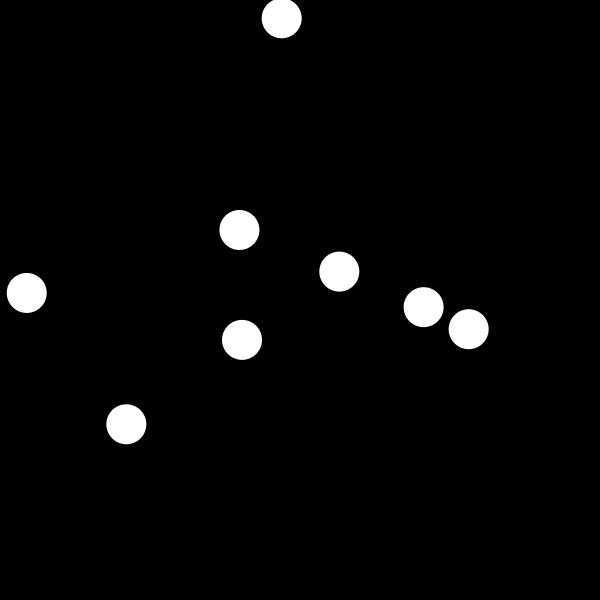

In [18]:
render_trace(trace)

## Perception

We are ultimately going to evaluate a tracking algorithm implemented via a particle filter ([Andrieu, C., & Doucet, A. 2010](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9868.2009.00736.x)). 

To start, we sample a trial using the deterministic components of our world model. To make inference more tractable, we provide the set of initial positions (but no velocities) as constraints for the particle filter. 

In [19]:
function sample_trial(params::WMParams, steps = 120)
    # sample initial state from prior of world model
    istate = initial_state(params)
    # initial state positions
    init_obs = choicemap()
    for i = 1:params.n
        x, y = istate[i].pos
        init_obs[:s0 => :trackers => i => :x] = x
        init_obs[:s0 => :trackers => i => :y] = y
    end
    # observations from 1 -> t
    state = istate
    xs = Vector{ChoiceMap}(undef, steps)
    for t = 1:steps
        state = resolve_steps(params, state)
        cm = choicemap()
        for i = 1:params.n
            addr = :kernel => t => :xs => i
            x,y = state[i].pos
            cm[addr] = [x,y]
        end
        xs[t] = cm
    end
    (init_obs, xs)
end;

In [20]:
init_obs, xs = sample_trial(params);
display(xs[1])

│
└── :kernel
    │
    └── 1
        │
        └── :xs
            │
            ├── 5 : [255.08110485966688, -113.07652079278435]
            │
            ├── 4 : [-105.81079010906852, -238.47119972544996]
            │
            ├── 6 : [21.30801245471956, 89.6940692039188]
            │
            ├── 7 : [-203.77806254344017, -64.4200481791784]
            │
            ├── 2 : [272.9768062726878, 244.3392292913391]
            │
            ├── 8 : [-58.595865423964966, 104.34175756432532]
            │
            ├── 3 : [8.884758010891895, -47.49061102337761]
            │
            └── 1 : [-256.9233008750684, 53.49227546039942]


Here, we implement a basic particle filter in Gen, that critically, performs a fixed series of rejuvenation moves over disc movement. The function `object_move` implements rejuvenation moves as a form of ancestral resampling, re-drawing from the already Gaussian prior, for the past few time steps.

In [40]:
function count_objects(trace::WMTrace)
    length(first(get_retval(trace)))
end

function object_move(trace::WMTrace, tracker::Int, 
                     tsteps::Int = 3)
    ct = first(get_args(trace))
    start_t = max(1, ct - tsteps + 1)
    selection = Gen.select()
    for t = start_t:ct
        addr = :kernel => t => :motion => :jitters => tracker
        push!(selection, addr)
    end
    (new_tr, ll, _) = regenerate(trace, selection)
end


function fixed_resource_step!(ps::Gen.ParticleFilterState,
                              nrejuv::Int64 = 10)
    np = length(ps.traces)
    for p = 1:np
        trace = ps.traces[p]
        nobj = count_objects(trace)
        for i = 1:nobj, _ = 1:nrejuv
            new_trace, alpha = object_move(trace, i)
            # Metropolis-Hastings acceptance function
            if log(rand()) < alpha
                trace = new_trace
            end
        end
        ps.traces[p]
    end
    return nothing
end


function fixed_perception_model(params::WMParams, obs::Vector{ChoiceMap};
                                nparticles::Int = 15, rejuv::Int = 20,
                                init_obs = choicemap())
    nt = length(obs)
    pf_state = initialize_particle_filter(world_model, (0, params), init_obs, nparticles)
    for t = 1:nt
        args = (t, params)
        argdiffs = (UnknownChange(), NoChange())
        Gen.maybe_resample!(pf_state)
        Gen.particle_filter_step!(pf_state, args, argdiffs, obs[t])
        fixed_resource_step!(pf_state, rejuv)
    end
    Gen.sample_unweighted_traces(pf_state, nparticles)
end;

In [41]:
@time fixed_traces = fixed_perception_model(params, xs; init_obs = init_obs);

 60.599503 seconds (1.02 G allocations: 74.969 GiB, 22.06% gc time, 0.08% compilation time)


### Visuals

Here, we extend our visualization scripts to look at the approximate posterior over object states. 

In [23]:
function draw_tracker(point, radius, hue)
    sethue(hue)
    setopacity(0.05)
    setline(5)
    setdash("solid")
    circle(point, radius, :stroke)
end

function scene_from_trace(ctx, trace::WMTrace)
    n_frames, params = get_args(trace)
    states = get_retval(trace)
    function frame(s, f)
        for (i, disc) = enumerate(states[f])
            hue = i <= 0.5 * params.n ? "purple" : "gray"
            draw_tracker(Point(disc.pos[1], disc.pos[2]), params.radius, hue)
        end
        return nothing
    end
    Scene(ctx, frame, 1:n_frames)
end

function scene_from_obs(ctx, xs::Vector{ChoiceMap})
    function frame(s, f)
       
        setopacity(1.0)
        positions = to_array(xs[f], Vector{Float64})
        n = length(positions)
        for (i, d) = enumerate(positions)
            i <= 0.5 * n ?  sethue("purple") : sethue("gray")
            star(Point(d[1], d[2]), 15.0; action= :fill)
        end
        return nothing
    end
    Scene(ctx, frame, 1:length(xs))
end

function render_traces(traces::Vector{<:WMTrace}, obs::Vector{ChoiceMap})
    n_frames = length(obs)
    tr = traces[1]
    _, params = get_args(tr)

    ctx = Movie(round(Int, 1.1*params.width), round(Int, 1.1*params.height), "discs", 1:n_frames)

    anims = [Scene(ctx, (s,f)->background("white"), 1:n_frames),
             scene_from_obs(ctx, obs)]
    ntraces = length(traces)
    for particle = traces
        push!(anims, scene_from_trace(ctx, particle))
    end
    Luxor.animate(ctx, anims, creategif=true, framerate =24)
end;

The stars denote the location of the detections $X$ and the circles denote the approximate posterior over object states. The purple states denote the ground truth targets, and the purple circles denote the model's representations of targets.

┌ Info: Frames for animation "discs" are being stored in directory: 
└ 	 /tmp/jl_IMhhLa
┌ Info: ... 120 frames saved in directory:
└ 	 /tmp/jl_IMhhLa
[ Info: GIF is: /tmp/jl_IMhhLa/discs.gif


Luxor.AnimatedGif("/tmp/jl_IMhhLa/discs.gif")
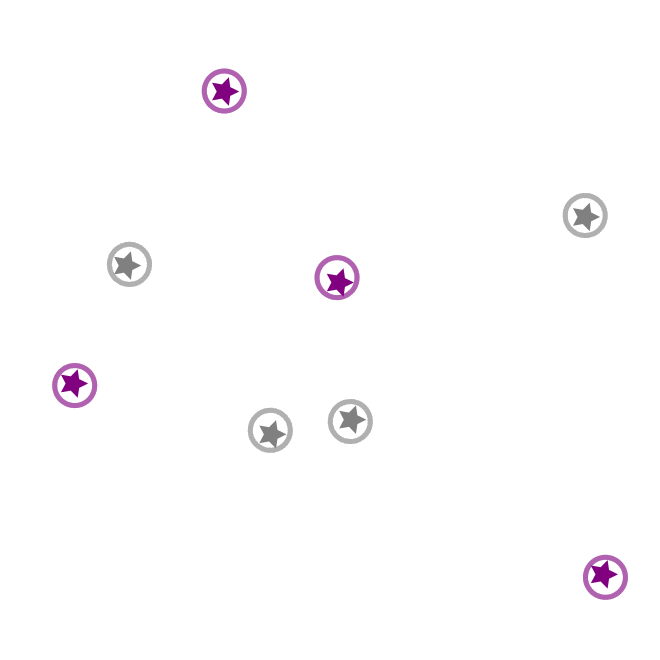

In [42]:
render_traces(fixed_traces, xs)

## Decision-making: Target Probability

This module receives the approximate posterior over disc states from perception and estimates the expected reward over target selections $Pr(\pi \mid S)$. This boils down to the expected target probability $Pr(s_i = \text{target} \mid S)$ - or the probability that a discs representation is tracking a detection corresponding to a target. 

### Helpers

Below are some helpers to interface with internal trace components and math. No need to fully parse these. 

In [25]:
function extract_rfs_subtrace(trace::WMTrace, t::Int64)
    # StaticIR names and nodes
    outer_ir = Gen.get_ir(world_model)
    kernel_node = outer_ir.call_nodes[2] # (:kernel)
    kernel_field = Gen.get_subtrace_fieldname(kernel_node)
    # subtrace for each time step
    vector_trace = getproperty(trace, kernel_field)
    sub_trace = vector_trace.subtraces[t]
    # StaticIR for `world_model_kernel`
    inner_ir = Gen.get_ir(world_model_kernel)
    xs_node = inner_ir.call_nodes[2] # (:xs)
    xs_field = Gen.get_subtrace_fieldname(xs_node)
    # `RFSTrace` for :xs
    getproperty(sub_trace, xs_field)
end

extract_rfs_subtrace (generic function with 1 method)

In [26]:
using LinearAlgebra 

function softmax(x::Array{Float64}, t::Float64 = 1.0)
    out = similar(x)
    softmax!(out, x, t)
    return out
end

function softmax!(out::Array{Float64}, x::Array{Float64}, t::Float64 = 1.0)
    nx = length(x)
    maxx = maximum(x)
    sxs = 0.0

    if maxx == -Inf
        out .= 1.0 / nx
        return nothing
    end

    @inbounds for i = 1:nx
        out[i] = @fastmath exp((x[i] - maxx) / t)
        sxs += out[i]
    end
    rmul!(out, 1.0 / sxs)
    return nothing
end

softmax! (generic function with 2 methods)

### Target probability

Here, target probability for each trace is estimated by computing the probability that for each detection $x_j$ explained by $s_i$, how likely is it that only other targets ($s_k, k \leq 4$) explain that same subset of detections. 
For example, if $s_1$ strongly explains $x_j$, but a distractor $s_5$ also explains $x_j$, then there is uncertainty over whether $s_1$ truly represents a target. In contrast, if both $s_1$ and $s_2$ explain $x_j$ at equal strength, even if there is maximal uncertainty over identity, there is high confidence that both are still targets. 

> Note: We estimate these values by marginalizing over the correspondence distribution in the RFS.

In [27]:
function target_probs(trace::WMTrace, temp::Float64 = 10.0)

    t = first(get_args(trace))
    rfs = extract_rfs_subtrace(trace, t)
    pt = rfs.ptensor
    nx,ne,np = size(pt)
    # Assume that the first half are targets
    ntargets = round(Int, 0.5 * ne)

    # normalize the log scores of each partition
    nls = log.(softmax(rfs.pscores, temp))
    
    # probability that each observation
    # is explained by a target
    x_weights = Vector{Float64}(undef, nx)
    for x = 1:nx
        xw = -Inf
        for p = 1:np, e = 1:ntargets
            if pt[x, e, p]
                xw = logsumexp(xw, nls[p])
            end
        end
        x_weights[x] = xw
    end

    # the ratio of observations explained by each target
    # weighted by the probability that the observation is
    # explained by other targets
    td_weights = fill(-Inf, ntargets)
    for i = 1:ntargets
        for p = 1:np
            ew = -Inf
            for x = 1:nx
                pt[x, i, p] || continue
                ew = x_weights[x]
                # assuming isomorphicity
                # (one association per partition)
                break
            end
            # P(e -> x) where x is associated with any other targets
            ew += nls[p]
            td_weights[i] = logsumexp(td_weights[i], ew)
        end
    end
    logsumexp(td_weights) - log(ntargets)
end

target_probs (generic function with 2 methods)

We can apply this function to a sample from the approximate posterior (note, this value is in log-space)

In [28]:
target_probs(fixed_traces[1])

-1.5868383530515118e-5

To get $Pr(\pi \mid S)$, we marginalize over the unweighted particles. (this is simply the average in log-space)

In [29]:
function estimate_marginal(traces::Vector{<:WMTrace}, fun)
    est = -Inf
    n = length(traces)
    for trace = traces
        est = logsumexp(est, fun(trace))
    end
    est - log(n)
end;

In [30]:
estimate_marginal(fixed_traces, target_probs)

-1.9447982849918333e-5

# Adaptive Computation

Now, we are ready to implement a variant of AC that replaces the `fixed_resource_step!` in the standard particle filter with `adaptive_computation!` that instead rations perceptual computations (`object_move`s) across objects and moments. 

The core of AC consists of the following three components:

1. The general resource involved with attention are perceptual computations $C_k$ that are targetable (can be selectively applied to representations) and unitized (well-formed time-complexity).
2. The task-relevance of an object at a moment $\Delta_k = \delta_k \pi \cdot \delta_k S$ is the impacts of further applying computations in terms of decision-making ($\delta_k \pi$) and perceptual inference ($\delta_k S$).
3. A dynamic algorithm that can both ration perceptual computations based on $\Delta$ as well as update task-relevance on-the-fly as the scene evolves.

Below, we start with `AdaptiveComputation` which defines the algorithm's parameters, and `TaskRelevance` which holds estimates of $\Delta$.

In [31]:
"""
Parameters that define adaptive computation behavior
"""
struct AdaptiveComputation
    "Importance temperature"
    tau::Float64
    "Load cap"
    load_cap::Int64
    "Minimum steps per object"
    base_steps::Int64
    # Slope and intercept for load curve
    load_x0::Float64
    load_m::Float64
end

mutable struct TaskRelevance
    deltas::Vector{Float64}
    new_deltas::Vector{Float64}
    steps::Vector{Int64}
end

" A helper function to initialize task-relevance"
function TaskRelevance(n::Int)
    TaskRelevance(fill(-Inf, n), fill(-Inf, n), zeros(Int64, n))
end
;

The `ration` function uses the current estimate of task-relevance to determine load and importance for a given time step. 

In [32]:
function ration(ac::AdaptiveComputation, tr::TaskRelevance)
    if all(isinf, tr.deltas)
        n = length(tr.deltas)
        return (0, fill(1.0/n, n))
    end
    mag = logsumexp(tr.deltas)
    load = ac.load_m * (mag + ac.load_x0)
    load = floor(Int64, clamp(load, 0., ac.load_cap))
    importance = softmax(tr.deltas, ac.tau)
    (load, importance)
end
;

Now, we implement some helper functions that can provide a running estimate of $\Delta$.

In [33]:
function update_impacts!(tr::TaskRelevance, dPi::Float64, dS::Float64, i::Int)
    tr.new_deltas[i] = logsumexp(tr.new_deltas[i], dPi + dS)
    tr.steps[i] += 1
    return nothing
end

function update_task_relevance!(tr::TaskRelevance)
    n = length(tr.deltas)
    for i = 1:n
        tr.deltas[i] = tr.new_deltas[i] - log(tr.steps[i])
    end
    fill!(tr.new_deltas, -Inf)
    fill!(tr.steps, 0)
    return nothing
end
;

Finally, we bring these components together in the `ac_model`. Note how similar it appears to the `fixed_resource_model`, with the critical exception of `adaptive_computation!` replacing the `fixed_resource_step!`. 

The model also returns the intermediate stages of importance and load so we can visualize them in action. 

In [43]:
function adaptive_computation!(task_relevance::TaskRelevance, 
                               ac::AdaptiveComputation,
                               trace::WMTrace, load, importance)
    pi = target_probs(trace, 10.0)
    nobj = count_objects(trace)
    for i = 1:nobj
        cks = round(Int, importance[i] * load) + ac.base_steps
        for ck = 1:cks
            new_trace, alpha = object_move(trace, i)
            new_pi = target_probs(new_trace, 10.0)
            dS = max(alpha, 0.)
            dPi = log(abs(new_pi - pi))
            update_impacts!(task_relevance, dPi, dS, i)
            # Metropolis-Hastings acceptance function
            if log(rand()) < alpha
                trace = new_trace
                pi = new_pi
            end
        end
    end
    return trace
end


function ac_model(ac::AdaptiveComputation,
                  params::WMParams, obs::Vector{ChoiceMap};
                  nparticles::Int = 15,
                  init_obs::ChoiceMap = choicemap())
    nt = length(obs)
    pf_state = initialize_particle_filter(world_model, (0, params), init_obs, nparticles)
    task_relevance = TaskRelevance(params.n)
    # Save some intermediate states
    loads = Vector{Int64}(undef, nt)
    importances = Vector{Vector{Float64}}(undef, nt)
    for t = 1:nt
        args = (t, params)
        argdiffs = (UnknownChange(), NoChange())
        Gen.maybe_resample!(pf_state)
        Gen.particle_filter_step!(pf_state, args, argdiffs, obs[t])
        load, importance = ration(ac, task_relevance)
        for p = 1:nparticles
            pf_state.traces[p] = 
                adaptive_computation!(task_relevance, ac, pf_state.traces[p],
                                      load, importance)
        end
        loads[t] = load
        importances[t] = round.(importance; digits=3)
        update_task_relevance!(task_relevance)
        # println(round.(task_relevance.deltas, digits=3))
    end
    traces = Gen.sample_unweighted_traces(pf_state, nparticles)
    (traces, loads, importances)
end;

Running the model, notice how much quicker it completes tracking! (somewhere between 5-6x faster!) With minor optimizations and parallel computing, this model could track in real-time!

In [44]:
ac_params = AdaptiveComputation(1.0, 20, 3, 4.0, 100.0)
@time (ac_traces, load, importance) = ac_model(ac_params, params, xs; init_obs = init_obs);

  9.627772 seconds (161.04 M allocations: 10.188 GiB, 21.76% gc time, 0.57% compilation time)


Part of this speedup comes from rationing load well below the maximum cap.

In [49]:
sum(load) / length(load)

1.325

But sometimes it exert maximal load!

In [50]:
maximum(load)

20

Extending our visualization tools to display attention patterns.

In [37]:
function draw_att_ring(point, radius, thickness, pattern, hue)
    sethue(hue)
    setopacity(0.025)
    setline(thickness)
    setdash(pattern)
    circle(point, 1.5 * radius, :stroke)
end

function att_from_trace(ctx, trace::WMTrace, load::Vector{Int64}, importance::Vector)
    n_frames, params = get_args(trace)
    states = get_retval(trace)
    function frame(s, f)
        thickness = load[f] / 6 * 10.0 + 5.0
        for (i, disc) = enumerate(states[f])
            point = Point(disc.pos[1], disc.pos[2])
            width = 35.0
            ring_weight = importance[f][i] * width 
            pattern = [ring_weight, width - ring_weight]
            draw_att_ring(point, params.radius, thickness, pattern, "red")
        end
        return nothing
    end
    Scene(ctx, frame, 1:n_frames)
end

function render_traces(traces::Vector{<:WMTrace}, obs::Vector{ChoiceMap}, load::Vector{Int64}, 
                       importance::Vector)
    tr = traces[1]
    n_frames, params = get_args(tr)

    ctx = Movie(round(Int, 1.1*params.width), round(Int, 1.1*params.height), "discs", 1:n_frames)

    anims = [Scene(ctx, (s,f)->background("white"), 1:n_frames),
             scene_from_obs(ctx, obs)]
    ntraces = length(traces)
    for particle = traces
        push!(anims, scene_from_trace(ctx, particle))
        push!(anims, att_from_trace(ctx, particle, load, importance))
    end
    Luxor.animate(ctx, anims, creategif=true, framerate =24)
end;

Look at that! The model, despite using vastly fewer perceptual computations, achieves better tracking accuracy. 

┌ Info: Frames for animation "discs" are being stored in directory: 
└ 	 /tmp/jl_hIf4br
┌ Info: ... 120 frames saved in directory:
└ 	 /tmp/jl_hIf4br
[ Info: GIF is: /tmp/jl_hIf4br/discs.gif


Luxor.AnimatedGif("/tmp/jl_hIf4br/discs.gif")
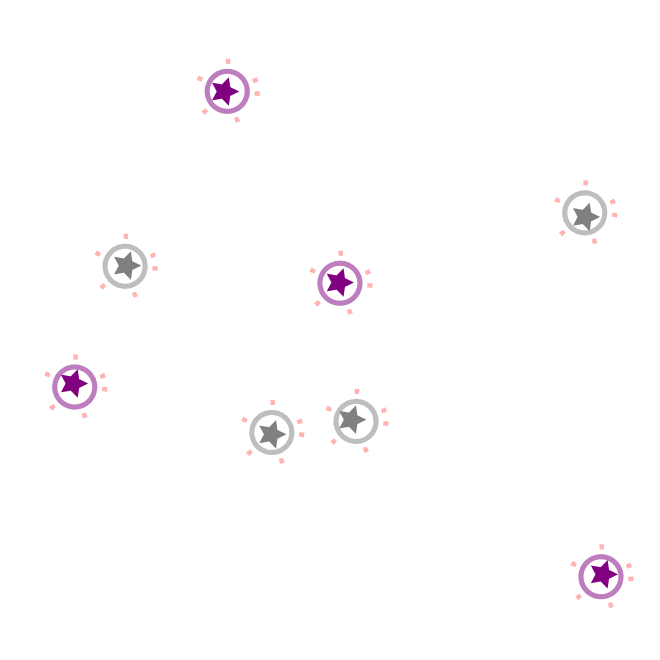

In [45]:
render_traces(ac_traces, xs, load, importance)